# Customer segmentation

- This is a personal project on customer segmentation using unsupervised machine learning methods. 
- I use the <a href="https://www.kaggle.com/puneetbhaya/online-retail">Online Retail </a> dataset from kaggle that contains transaction records occuring from 01/12/2010 to 09/12/2011 for a UK-based online retail company.

- Firstly, what is customer segmentation?
    - It is the problem of uncovering information about a company's customer base, based on their interactions with the business. In most cases, this is regarding their purchase behaviour and patterns. 
    - I will be using RFN (Recency, Frequency, Monetary Value), and clustering.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-all-libraries" data-toc-modified-id="Load-all-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load all libraries</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Exploratory-Data-Analysis-(EDA)" data-toc-modified-id="Exploratory-Data-Analysis-(EDA)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Data Analysis (EDA)</a></span></li><li><span><a href="#Customer-Segmentation" data-toc-modified-id="Customer-Segmentation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Customer Segmentation</a></span><ul class="toc-item"><li><span><a href="#RFM-model" data-toc-modified-id="RFM-model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>RFM model</a></span><ul class="toc-item"><li><span><a href="#Recency" data-toc-modified-id="Recency-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Recency</a></span></li><li><span><a href="#Frequency" data-toc-modified-id="Frequency-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Frequency</a></span></li><li><span><a href="#Monetary-Value" data-toc-modified-id="Monetary-Value-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Monetary Value</a></span></li></ul></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Data preprocessing</a></span></li></ul></li></ul></li></ul></div>

## Load all libraries

In [2]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pickle
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *

## Load data

```python
cs_df = pd.read_excel(io=r'data/Online Retail.xlsx')
pickle.dump(cs_df, open('data/Online Retail.pkl', 'wb'))
```

In [3]:
cs_df = pickle.load(open('data/Online Retail.pkl', 'rb'))
cs_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [4]:
print(cs_df.shape)

(541909, 8)


## Exploratory Data Analysis (EDA)

- Below is a function that analyses general characteristics of the data, similar to the str() function from R.
    - Returns types, counts, distinct/null counts, missing ratio, unique values of each feature.
    - For supervised learning, you can provide the target variable to the pred parameter and it will return the study of correlations too.

In [5]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques.squeeze(axis=0), skewness, kurtosis], axis=1, sort=True)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques.squeeze(axis=0), skewness, kurtosis, corr], axis = 1, sort=True)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

details = rstr(cs_df)
details.sort_values(by='missing ration', ascending=False)

Data shape: (541909, 8)
___________________________
Data types:
 object            4
float64           2
int64             1
datetime64[ns]    1
Name: types, dtype: int64
___________________________


types  counts  distincts   nulls  missing ration  \
CustomerID          float64  406829       4373  135080       24.926694   
Description          object  540455       4224    1454        0.268311   
Country              object  541909         38       0        0.000000   
InvoiceDate  datetime64[ns]  541909      23260       0        0.000000   
InvoiceNo            object  541909      25900       0        0.000000   
Quantity              int64  541909        722       0        0.000000   
StockCode            object  541909       4070       0        0.000000   
UnitPrice           float64  541909       1630       0        0.000000   

                                                       uniques    skewness  \
CustomerID   [17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...    0.029835   
Description  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...         NaN   
Country      [United Kingdom, France, Australia, Netherland...         NaN   
InvoiceDate  [2010-12-01T08:26:00.000000000, 2010-12-01T08:...         NaN   
InvoiceNo    [536365, 536366, 536367, 536368, 536369, 53637...         NaN   
Quantity     [6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...   -0.264076   
StockCode    [85123A, 71053, 84406B, 84029G, 84029E, 22752,...         NaN   
UnitPrice    [2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...  186.506972   

                  kurtosis  
CustomerID       -1.179982  
Description            NaN  
Country                NaN  
InvoiceDate            NaN  
InvoiceNo              NaN  
Quantity     119769.160031  
StockCode              NaN  
UnitPrice     59005.719097

- Actually, df.info() displays similar info that str() generates in R.

In [6]:
cs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- We see that **CusttomerID** and **Description** have 135080 and 1454 null entries, respectively.

- From Kaggle we find the description of each feature/column.
    - **InvoiceNo**: A unique identifier for the invoice. An invoice number shared across rows means that those transactions were performed in a single invoice (multiple purchases).
    - **StockCode**: Identifier for items contained in an invoice.
    - **Description**: Textual description of each of the stock item.
    - **Quantity**: The quantity of the item purchased.
    - **InvoiceDate**: Date of purchase.
    - **UnitPrice**: Value of each item.
    - **CustomerID**: Identifier for customer making the purchase.
    - **Country**: Country of customer.

In [7]:
cs_df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

- We observe that **Quantity** and **UnitPrice** in fact have negative values, suggesting that we may have some *return* transactions in the data.
- We remove these records as our goal is customer segmentation based on *purchasing.*
- Let's quickly have a deeper look at whether there are records with both features being negative or if one of them is negative and the other zero.

In [8]:
print('Check if we had negative quantity and prices at same register:',
     'No' if cs_df[(cs_df.Quantity<0) & (cs_df.UnitPrice<0)].shape[0] == 0 else 'Yes', '\n')

Check if we had negative quantity and prices at same register: No 



In [9]:
print('Check how many register we have where quantity is negative',
      'and prices is 0 or vice-versa:',
      cs_df[(cs_df.Quantity<=0) & (cs_df.UnitPrice<=0)].shape[0])

Check how many register we have where quantity is negative and prices is 0 or vice-versa: 1336


In [10]:
print('What is the customer ID of the registers above:',
      cs_df.loc[(cs_df.Quantity<=0) & (cs_df.UnitPrice<=0)].CustomerID.unique())

What is the customer ID of the registers above: [nan]


In [11]:
print('% of Negative Quantity: {:3.2%}'.format(cs_df[(cs_df.Quantity<0)].shape[0]/cs_df.shape[0]))

% of Negative Quantity: 1.96%


In [12]:
cs_df.loc[(cs_df.Quantity<0) & ~(cs_df.CustomerID.isnull())]

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice  CustomerID         Country  
141    2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154    2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235    2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236    2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237    2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
...                    ...        ...         ...             ...  
540449 2011-12-09 09:57:00       0.83     14397.0  United Kingdom  
541541 2011-12-09 10:28:00     224.69     15498.0  United Kingdom  
541715 2011-12-09 11:57:00      10.95     15311.0  United Kingdom  
541716 2011-12-09 11:58:00       1.25     17315.0  United Kingdom  
541717 2011-12-09 11:58:00       1.25     17315.0  United Kingdom  

[8905 rows x 8 columns]

In [13]:
print('Registers with negative quantity have Invoice that start with:', 
      cs_df.loc[(cs_df.Quantity<0) & ~(cs_df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

Registers with negative quantity have Invoice that start with: ['C']


In [14]:
print('See an example of negative quantity and others related records:')
display(cs_df[(cs_df.CustomerID==12472) & (cs_df.StockCode==22244)])

See an example of negative quantity and others related records:


InvoiceNo StockCode                 Description  Quantity  \
1973     C536548     22244  3 HOOK HANGER MAGIC GARDEN        -4   
9438      537201     22244  3 HOOK HANGER MAGIC GARDEN        12   
121980    546843     22244  3 HOOK HANGER MAGIC GARDEN        12   

               InvoiceDate  UnitPrice  CustomerID  Country  
1973   2010-12-01 14:33:00       1.95     12472.0  Germany  
9438   2010-12-05 14:19:00       1.95     12472.0  Germany  
121980 2011-03-17 12:40:00       1.95     12472.0  Germany

In [15]:
print('Check register with negative UnitPrice:')
cs_df[(cs_df.UnitPrice<0)]

Check register with negative UnitPrice:


InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

In [16]:
print("Sales records with Customer ID but zero Unit Price: #", cs_df[(cs_df.UnitPrice==0)  & ~(cs_df.CustomerID.isnull())].shape[0])
cs_df[(cs_df.UnitPrice==0)  & ~(cs_df.CustomerID.isnull())]

Sales records with Customer ID but zero Unit Price: # 40


InvoiceNo StockCode                          Description  Quantity  \
9302      537197     22841         ROUND CAKE TIN VINTAGE GREEN         1   
33576     539263     22580         ADVENT CALENDAR GINGHAM SACK         4   
40089     539722     22423             REGENCY CAKESTAND 3 TIER        10   
47068     540372     22090              PAPER BUNTING RETROSPOT        24   
47070     540372     22553               PLASTERS IN TIN SKULLS        24   
56674     541109     22168        ORGANISER WOOD ANTIQUE WHITE          1   
86789     543599    84535B         FAIRY CAKES NOTEBOOK A6 SIZE        16   
130188    547417     22062  CERAMIC BOWL WITH LOVE HEART DESIGN        36   
139453    548318     22055   MINI CAKE STAND  HANGING STRAWBERY         5   
145208    548871     22162          HEART GARLAND RUSTIC PADDED         2   
157042    550188     22636   CHILDS BREAKFAST SET CIRCUS PARADE         1   
187613    553000     47566                        PARTY BUNTING         4   
198383    554037     22619            SET OF 6 SOLDIER SKITTLES        80   
279324    561284     22167           OVAL WALL MIRROR DIAMANTE          1   
282912    561669     22960             JAM MAKING SET WITH JARS        11   
285657    561916         M                               Manual         1   
298054    562973     23157           SET OF 6 NATIVITY MAGNETS        240   
314745    564651     23270     SET OF 2 CERAMIC PAINTED HEARTS         96   
314746    564651     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER       192   
314747    564651     22955             36 FOIL STAR CAKE CASES        144   
314748    564651     21786                   POLKADOT RAIN HAT        144   
358655    568158      PADS           PADS TO MATCH ALL CUSHIONS         1   
361825    568384         M                               Manual         1   
379913    569716     22778                   GLASS CLOCHE SMALL         2   
395529    571035         M                               Manual         1   
420404    572893     21208          PASTEL COLOUR HONEYCOMB FAN         5   
436428    574138     23234        BISCUIT TIN VINTAGE CHRISTMAS       216   
436597    574175     22065       CHRISTMAS PUDDING TRINKET POT         12   
436961    574252         M                               Manual         1   
439361    574469     22385            JUMBO BAG SPACEBOY DESIGN        12   
446125    574879     22625                   RED KITCHEN SCALES         2   
446793    574920     22899         CHILDREN'S APRON DOLLY GIRL          1   
446794    574920     23480       MINI LIGHTS WOODLAND MUSHROOMS         1   
454463    575579     22437        SET OF 9 BLACK SKULL BALLOONS        20   
454464    575579     22089        PAPER BUNTING VINTAGE PAISLEY        24   
479079    577129     22464          HANGING METAL HEART LANTERN         4   
479546    577168         M                               Manual         1   
480649    577314     23407       SET OF 2 TRAYS HOME SWEET HOME         2   
485985    577696         M                               Manual         1   
502122    578841     84826       ASSTD DESIGN 3D PAPER STICKERS     12540   

               InvoiceDate  UnitPrice  CustomerID         Country  
9302   2010-12-05 14:02:00        0.0     12647.0         Germany  
33576  2010-12-16 14:36:00        0.0     16560.0  United Kingdom  
40089  2010-12-21 13:45:00        0.0     14911.0            EIRE  
47068  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
47070  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
56674  2011-01-13 15:10:00        0.0     15107.0  United Kingdom  
86789  2011-02-10 13:08:00        0.0     17560.0  United Kingdom  
130188 2011-03-23 10:25:00        0.0     13239.0  United Kingdom  
139453 2011-03-30 12:45:00        0.0     13113.0  United Kingdom  
145208 2011-04-04 14:42:00        0.0     14410.0  United Kingdom  
157042 2011-04-14 18:57:00        0.0     12457.0     Switzerland  
187613 2011-05-12 15:21:00       

- From EDA, we saw that there exists no record where both price and quantity are negative, but there are 1336 instances where one of them is negative and the other 0. We also saw for all these records we do not have the custoemr ID.
    - ==> Conclude by removing these records completely (where one of price or quantity is negative). 
    - We also remove 135080 records without customer ID.

In [17]:
# Remove instances withou CustomerID
cs_df = cs_df[~(cs_df.CustomerID.isnull())]

# Remove negative or return transactions
cs_df = cs_df[~(cs_df.Quantity<0)]
cs_df = cs_df[cs_df.UnitPrice>0]

details = rstr(cs_df)
details.sort_values(by='distincts', ascending=False)

Data shape: (397884, 8)
___________________________
Data types:
 object            4
float64           2
int64             1
datetime64[ns]    1
Name: types, dtype: int64
___________________________


types  counts  distincts  nulls  missing ration  \
InvoiceNo            object  397884      18532      0             0.0   
InvoiceDate  datetime64[ns]  397884      17282      0             0.0   
CustomerID          float64  397884       4338      0             0.0   
Description          object  397884       3877      0             0.0   
StockCode            object  397884       3665      0             0.0   
UnitPrice           float64  397884        440      0             0.0   
Quantity              int64  397884        301      0             0.0   
Country              object  397884         37      0             0.0   

                                                       uniques    skewness  \
InvoiceNo    [536365, 536366, 536367, 536368, 536369, 53637...   -0.178524   
InvoiceDate  [2010-12-01T08:26:00.000000000, 2010-12-01T08:...         NaN   
CustomerID   [17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...    0.025729   
Description  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...         NaN   
StockCode    [85123A, 71053, 84406B, 84029G, 84029E, 22752,...         NaN   
UnitPrice    [2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...  204.032727   
Quantity     [6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...  409.892972   
Country      [United Kingdom, France, Australia, Netherland...         NaN   

                  kurtosis  
InvoiceNo        -1.200748  
InvoiceDate            NaN  
CustomerID       -1.180822  
Description            NaN  
StockCode              NaN  
UnitPrice     58140.396673  
Quantity     178186.243253  
Country                NaN

- Note that we still have more distinct counts of **Description** than **StockCode** (There should be at least as many StockCodes as Descriptions).
    - So there still is inconsistency that requires further investigation.

In [18]:
cat_des_df = cs_df.groupby(["StockCode","Description"]).count().reset_index()
cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index().head()
# show records where one stockcode has more than one descriptions

index  StockCode
0  23196          4
1  23236          4
2  23203          3
3  23366          3
4  23126          3

In [19]:
arbitrary_ind = 4
cs_df[cs_df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index()['index'][arbitrary_ind]]['Description'].unique()

array(['DOLLCRAFT GIRL AMELIE KIT', 'FELTCRAFT GIRL AMELIE KIT',
       'DOLLCRAFT GIRL AMELIE'], dtype=object)

- We see that actually these 3 descriptions mean the same thing, but some records just had typos.
- Such simple spelling mistakes can end up in reducing data quality and an erroneous analysis.

In [20]:
cs_df[["StockCode", "Description"]].groupby(by=["StockCode"]).apply(pd.DataFrame.mode).reset_index(drop=True)

StockCode                   Description
0        10002   INFLATABLE POLITICAL GLOBE 
1        10080      GROOVY CACTUS INFLATABLE
2        10120                  DOGGY RUBBER
3        10125       MINI FUNKY DESIGN TAPES
4        10133  COLOURING PENCILS BROWN TUBE
...        ...                           ...
3661        C2                      CARRIAGE
3662       DOT                DOTCOM POSTAGE
3663         M                        Manual
3664      PADS    PADS TO MATCH ALL CUSHIONS
3665      POST                       POSTAGE

[3666 rows x 2 columns]

- We can use pysqldf() to run SQL-like queries on pandas dataframes.
    - Could be more intuitive/easier than working with pandas operations.

In [21]:
unique_desc = cs_df[["StockCode", "Description"]].groupby(by=["StockCode"]).\
                apply(pd.DataFrame.mode).reset_index(drop=True)
q = '''
select df.InvoiceNo, df.StockCode, un.Description, df.Quantity, df.InvoiceDate,
       df.UnitPrice, df.CustomerID, df.Country
from cs_df as df INNER JOIN 
     unique_desc as un on df.StockCode = un.StockCode
'''

cs_df = pysqldf(q)

In [22]:
cs_df.InvoiceDate = pd.to_datetime(cs_df.InvoiceDate)
cs_df['amount'] = cs_df.Quantity*cs_df.UnitPrice
cs_df.CustomerID = cs_df.CustomerID.astype('Int64')

details = rstr(cs_df)
details.sort_values(by='distincts', ascending=False)

Data shape: (397884, 9)
___________________________
Data types:
 object            3
int64             2
float64           2
Int64             1
datetime64[ns]    1
Name: types, dtype: int64
___________________________


types  counts  distincts  nulls  missing ration  \
InvoiceNo             int64  397884      18532      0             0.0   
InvoiceDate  datetime64[ns]  397884      17282      0             0.0   
CustomerID            Int64  397884       4338      0             0.0   
StockCode            object  397884       3665      0             0.0   
Description          object  397884       3647      0             0.0   
amount              float64  397884       2939      0             0.0   
UnitPrice           float64  397884        440      0             0.0   
Quantity              int64  397884        301      0             0.0   
Country              object  397884         37      0             0.0   

                                                       uniques    skewness  \
InvoiceNo    [536365, 536366, 536367, 536368, 536369, 53637...   -0.178524   
InvoiceDate  [2010-12-01T08:26:00.000000000, 2010-12-01T08:...         NaN   
CustomerID   [17850, 13047, 12583, 13748, 15100, 15291, 146...    0.025729   
StockCode    [85123A, 71053, 84406B, 84029G, 84029E, 22752,...         NaN   
Description  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...         NaN   
amount       [15.299999999999999, 20.34, 22.0, 15.3, 25.5, ...  451.443182   
UnitPrice    [2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...  204.032727   
Quantity     [6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...  409.892972   
Country      [United Kingdom, France, Australia, Netherland...         NaN   

                  kurtosis  
InvoiceNo        -1.200748  
InvoiceDate            NaN  
CustomerID       -1.180822  
StockCode              NaN  
Description            NaN  
amount       232155.117219  
UnitPrice     58140.396673  
Quantity     178186.243253  
Country                NaN

- Now we have less Descriptions than the number of distinct StockCodes. 
    - Makes sense, could have same description for multiple items (note the other way doesn't make sense, and is what we had before).

In [23]:
cs_df.Country

0         United Kingdom
1         United Kingdom
2         United Kingdom
3         United Kingdom
4         United Kingdom
               ...      
397879            France
397880            France
397881            France
397882            France
397883            France
Name: Country, Length: 397884, dtype: object

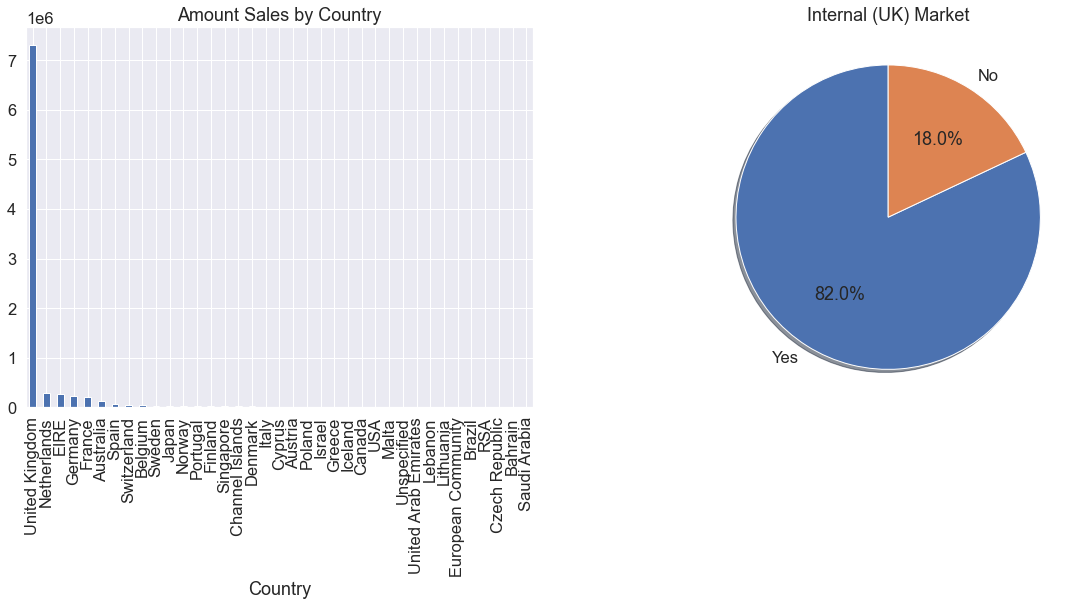

In [24]:
fig = plt.figure(figsize=(20, 7))
f1 = fig.add_subplot(121)
g = cs_df.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
cs_df['Internal'] = cs_df.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = cs_df.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal (UK) Market')
plt.show()

In [26]:
def int_to_string(i):
    string = ''
    while True:
        i, remainder = divmod(i, 10)
        string = chr(ord('0') + remainder) + string
        if i == 0:
            break
    return string

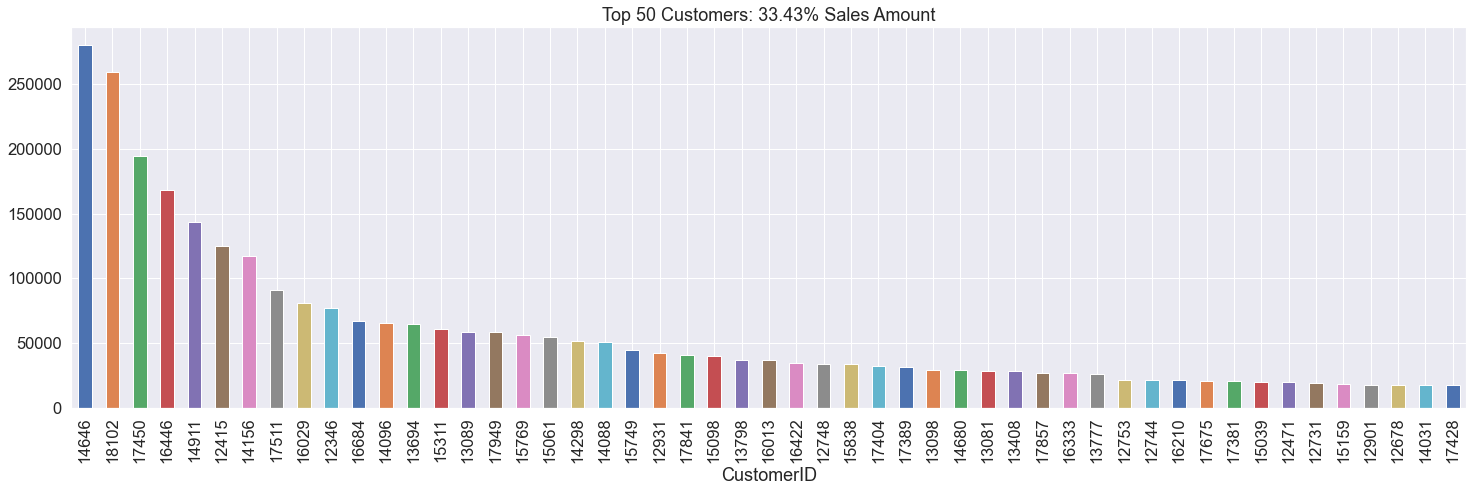

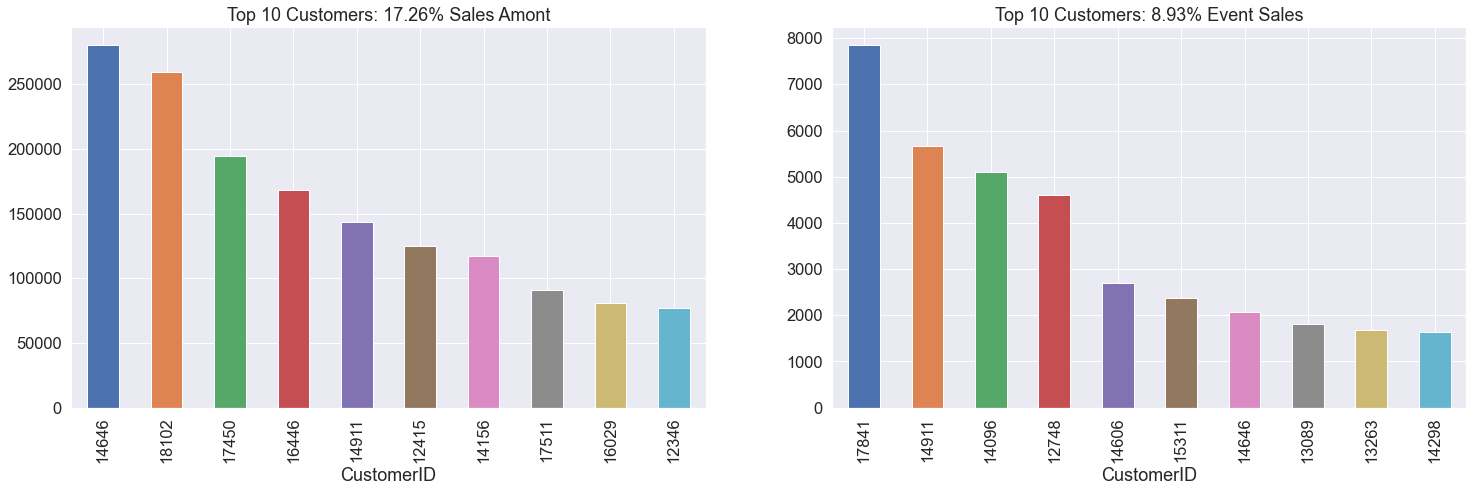

In [27]:
fig = plt.figure(figsize=(25, 7))

PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/cs_df.amount.sum()) * 100, 2)
color = ['C' + int_to_string(i) for i in range(50)]
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top 50 Customers: {:3.2f}% Sales Amount'.format(PercentSales),
        color = color)


fig = plt.figure(figsize=(25, 7))

f1 = fig.add_subplot(121)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
color = ['C' + int_to_string(i) for i in range(10)]
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales),
         color=color)

f1 = fig.add_subplot(122)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales),
        color=color)

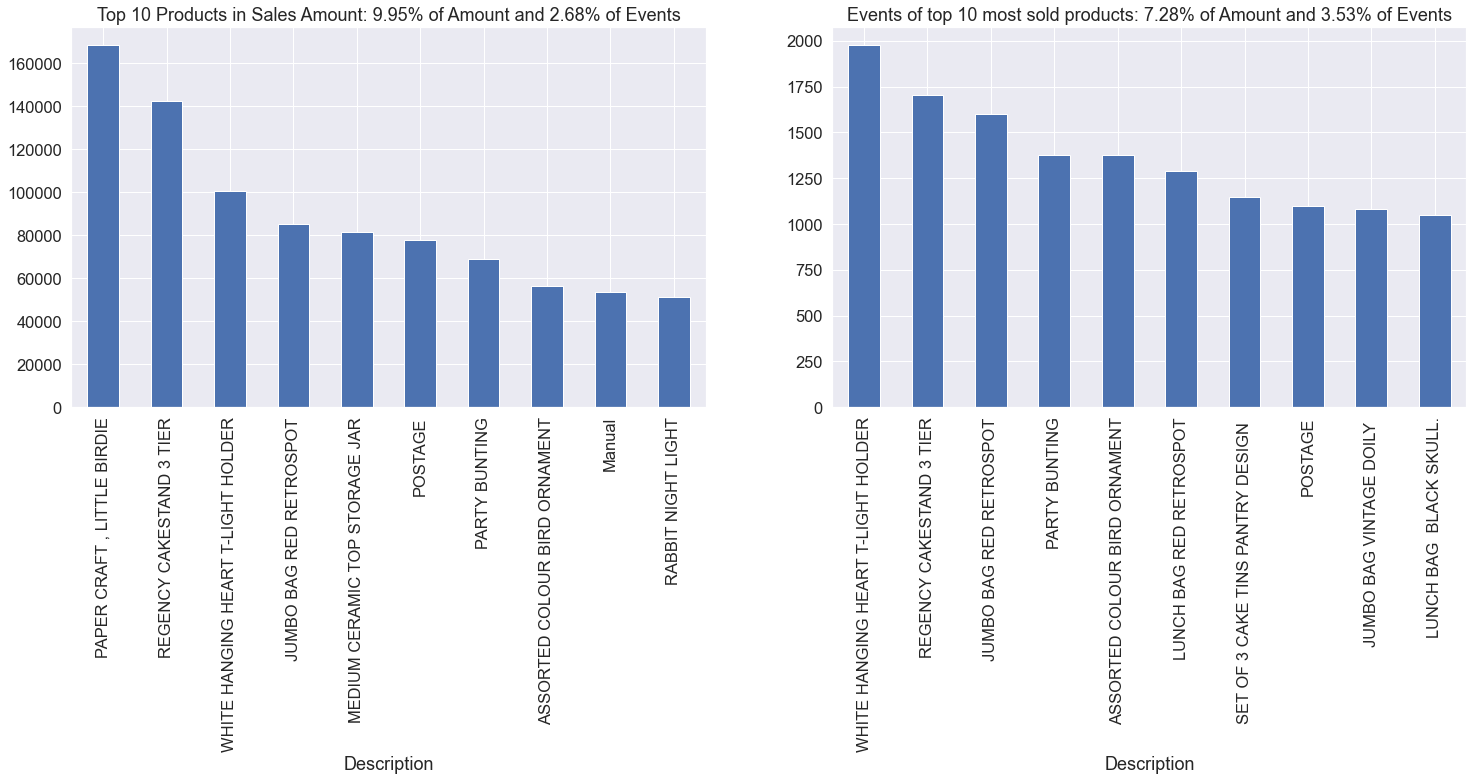

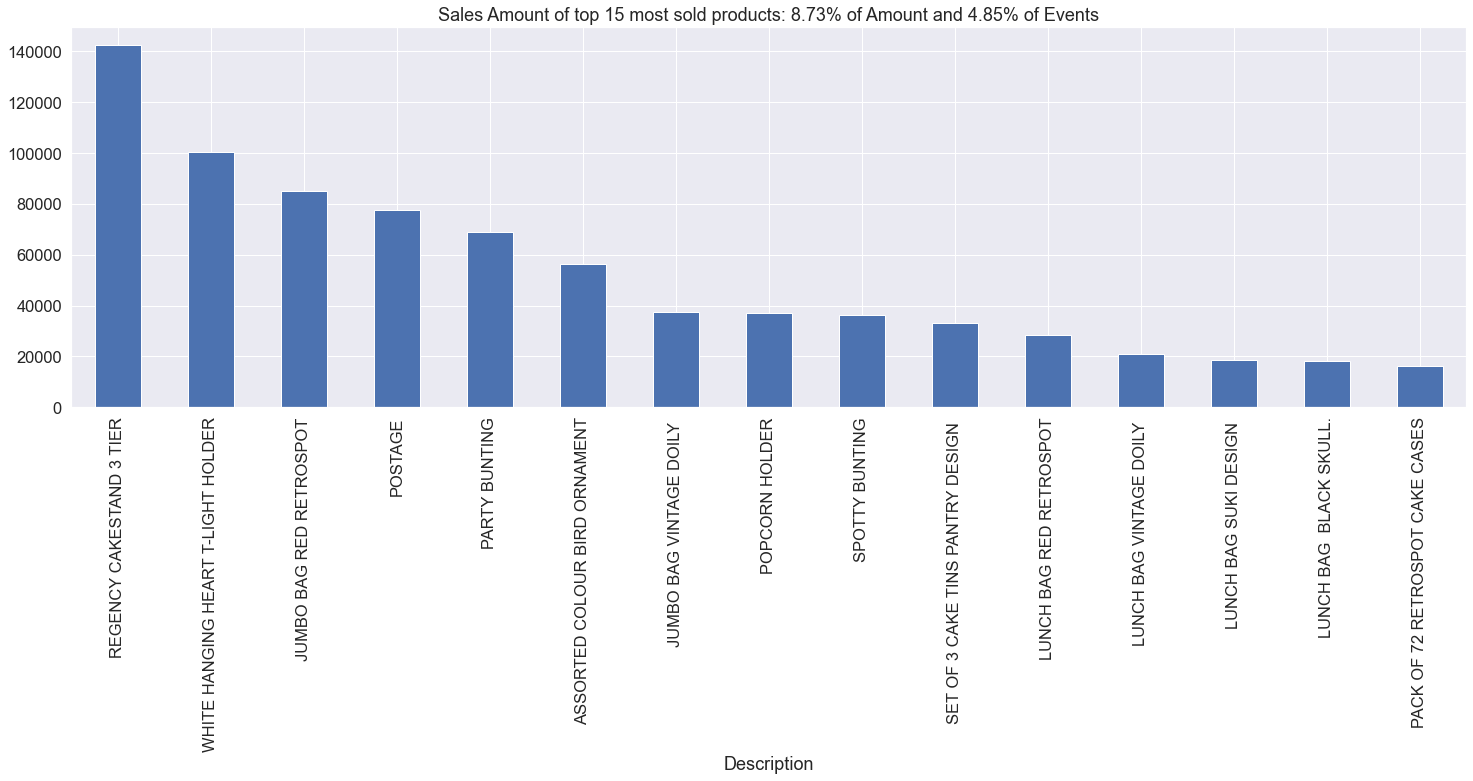

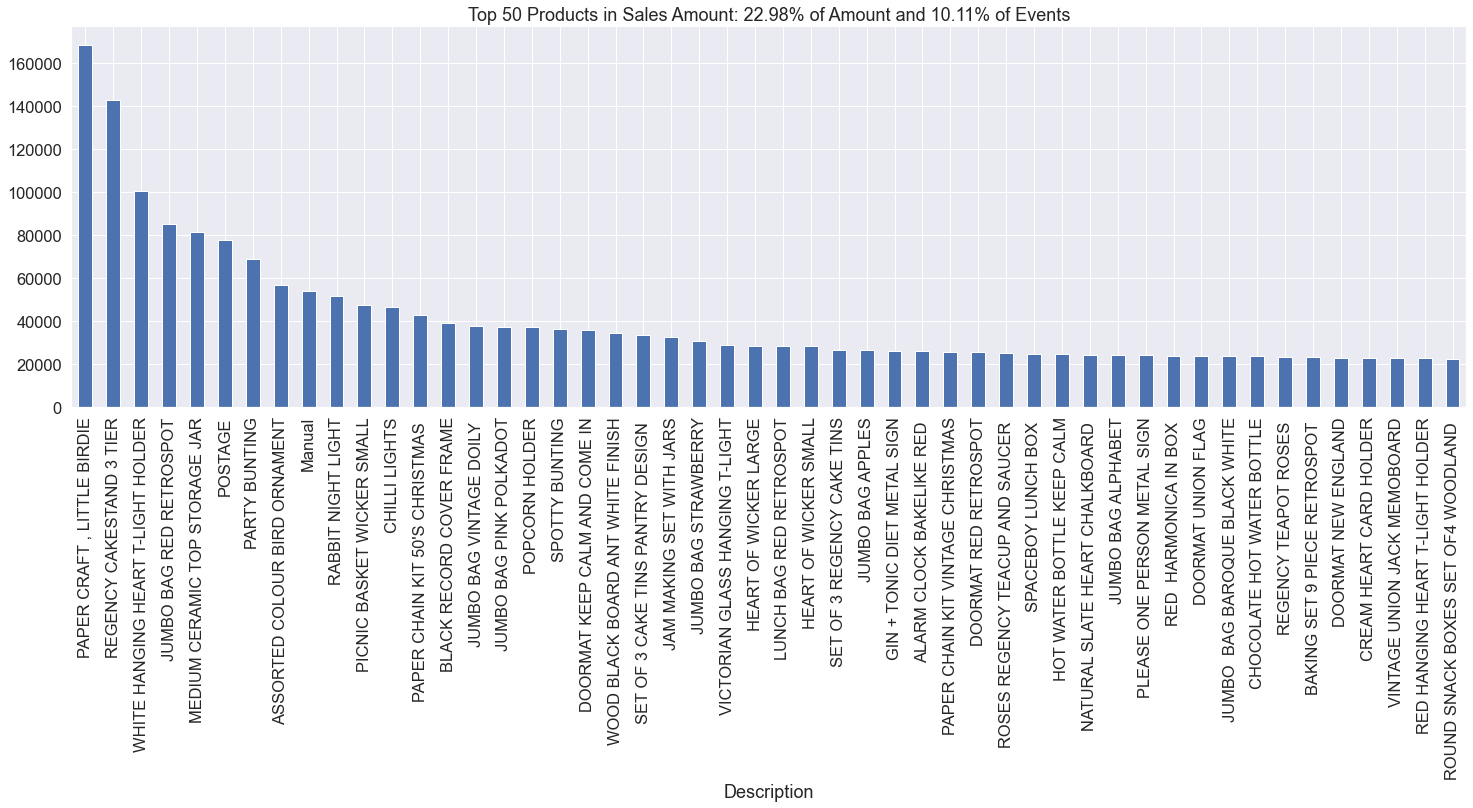

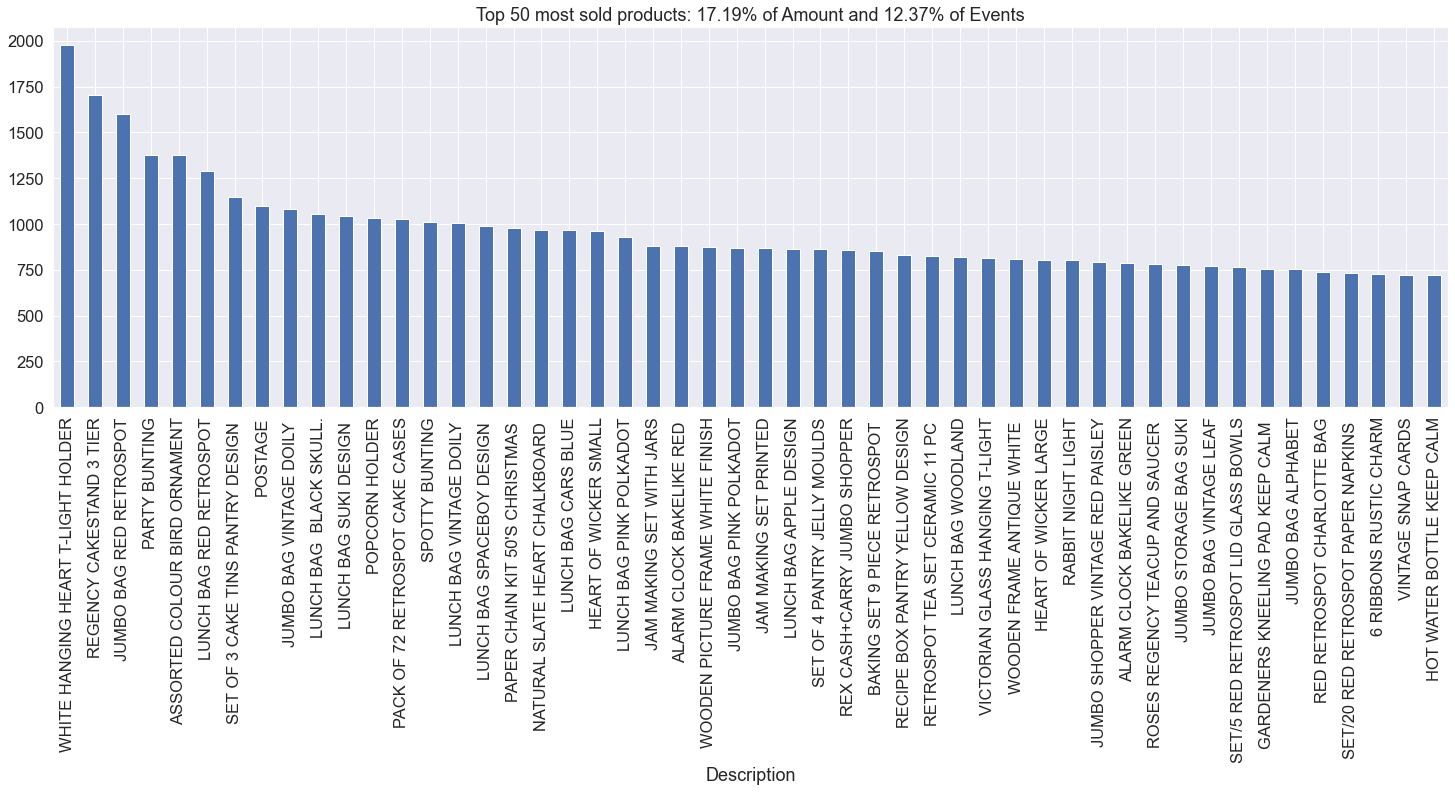

In [28]:
AmoutSum = cs_df.groupby(["Description"]).amount.sum().sort_values(ascending = False)
inv = cs_df[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
      agg(np.size).sort_values(ascending = False)

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(AmoutSum[:10].index)
PercentSales =  np.round((AmoutSum[Top10].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
PercentSales =  np.round((AmoutSum[Top10Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:15].index)
PercentSales =  np.round((AmoutSum[Top15ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top15ev].sort_values(ascending = False).\
    plot(kind='bar', 
         title='Sales Amount of top 15 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales =  np.round((AmoutSum[Top50].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top50].\
    plot(kind='bar', 
         title='Top 50 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:50].index)
PercentSales =  np.round((AmoutSum[Top50Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top50Ev].\
    plot(kind='bar', title='Top 50 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

## Customer Segmentation

- Now I will perform customer segmentation that involves grouping the company's customer basis into different sections/segments based on various customer attributes/features.
- Customer segmentation is based on premise of finding differences and similarities among the customes' transaction behaviour and patterns.
- Typically in customer segmentation, we use the RFM (Recency, Frequency, Monetary value ) model or unsupervised methods like clustering.

### RFM model

- <a href = "https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp"> RFM</a> is a marketing analysis tool used to identify a company's best customers by using certain measures.
    - **Recency**: How recently a customer has made a purchase.
    - **Frequency**: How often a customer makes a purchase.
    - **Monetary Value**: How much money a customer has spent on purchases.

#### Recency

- We need to create a feature/variable for recency.
- We will set the reference date as the last transaction date in our data plus one day.
- Recency is calculated as the # of days before the reference date when a customer made their last purchase.

In [35]:
(cs_df.InvoiceDate.max() + datetime.timedelta(days = 1) - cs_df.InvoiceDate).astype('timedelta64[D]')

0         374.0
1         374.0
2         374.0
3         374.0
4         374.0
          ...  
397879      1.0
397880      1.0
397881      1.0
397882      1.0
397883      1.0
Name: InvoiceDate, Length: 397884, dtype: float64

In [47]:
refrence_date = cs_df.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
cs_df['days_since_last_purchase'] = (refrence_date - cs_df.InvoiceDate).astype('timedelta64[D]')
# groupby customer and .min() to find the most recent date for each customer
customer_history_df =  cs_df[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


count          mean          std      min       25%      50%  \
CustomerID  4338.0  15300.408022  1721.808492  12346.0  13813.25  15299.5   
recency     4338.0     92.536422   100.014169      1.0     18.00     51.0   

                 75%      max  
CustomerID  16778.75  18287.0  
recency       142.00    374.0

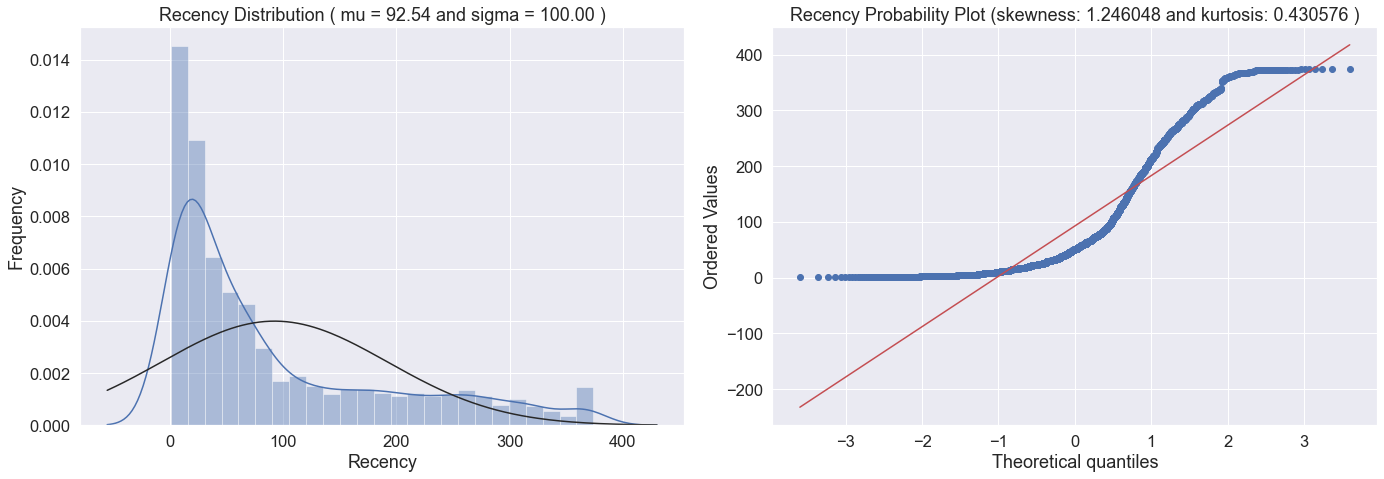

In [48]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.recency, 'Recency')

- From graph 1 we see the sales recency distribution is positively (right) skewed, i.e. a peak on the left and a long tail to the right.
- From the QQ (probability) plot, we see sales recency also does not align with the diagonal red line that represents normal distribution. 
- Positive value of skewness (1.25) confirms the lack of symmetry in sales recency.
- Kurtosis measures whether the data are heavy-tailed or light-tailed. A Normal distribution has a kurtosis of 3. Compared to a normal distribution, sales recency is lighter-tailed, i.e. we are less likely to observe extreme outliers. 

#### Frequency

In [49]:
# compute number of invoices (purchase events) for each customer
# (one invoice could be associated with several records for different stockcodes)
customer_freq = (cs_df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()

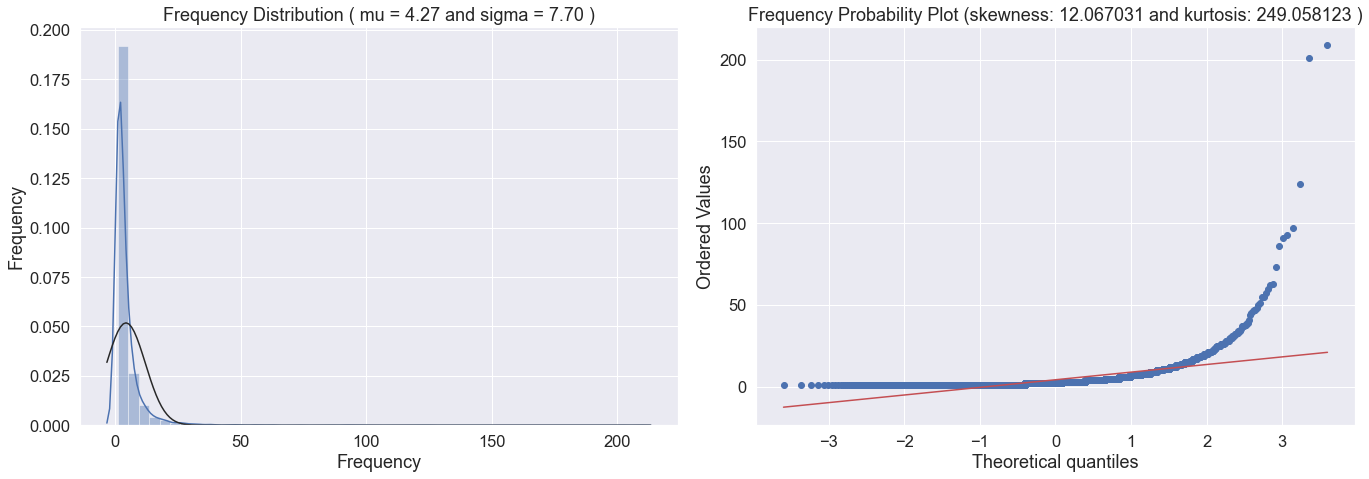

In [70]:
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

- Again, sales frequency distribution is positively skewed. (longer tail to the right).
- From the QQ plot, we see that sales frequency does not align with the diagonal red line and confirm positively skewedness.
- With skewness of +12 we confirm a high lack of symmetry and with kurtosis of 249 we see that this is an extremely heavy-tailed dilstribution.
    - Has some outliers that are very distinct from others from the right-most side of QQ plot.

#### Monetary Value

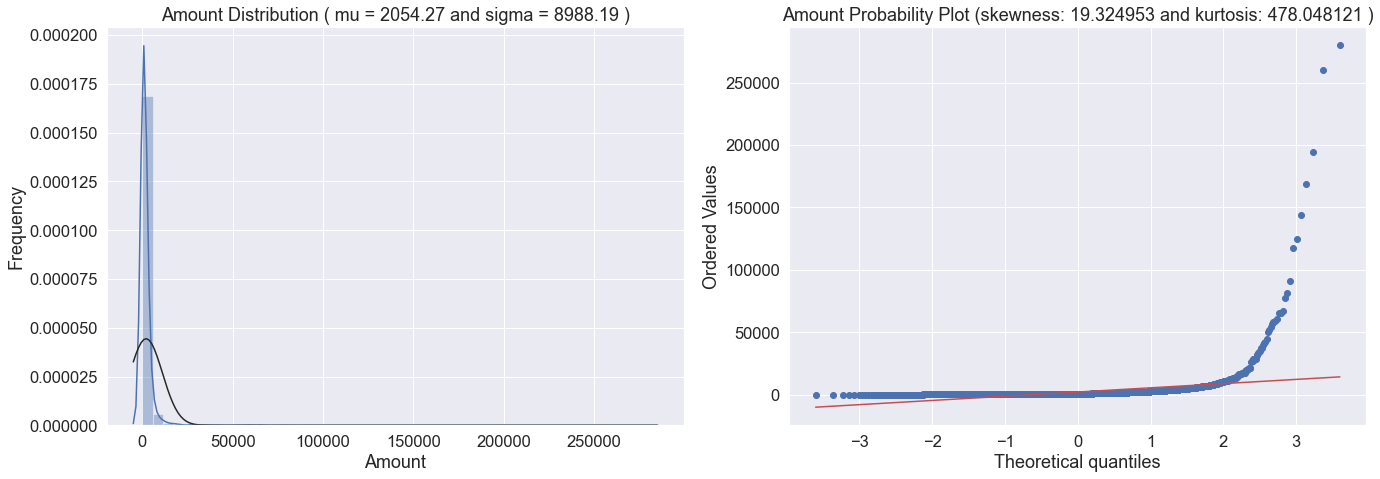

In [72]:
customer_monetary_val = cs_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
QQ_plot(customer_history_df.amount, 'Amount')

- Sales amount distribution is positively skewed again.
- It does not align with the diagonal red line, so is far from normal.
- With high values of skewness and kurtosis, we confirm high lack of symmetry and very extreemly heavy-tailedness of distribution.
    - Has more outliers than before.

In [73]:
customer_history_df.describe()

CustomerID      recency    frequency         amount
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000

- We have so far found some interesting insights from customers' transaction data using the RFM model.
- Now that we have our new `customer_history_df` dataframe where each row represents RFM values of one customer, we can perform clustering methods to group/cluster each customer/data point.

### Clustering

#### Data preprocessing